## Files
- train.csv - the training data, with columns as follows:

1. seq_id: unique identifier of each protein variants
2. protein_sequence: amino acid sequence of each protein variant. The stability (as measured by tm) of protein is determined by its protein sequence. (Please note that most of the sequences in the test data have the same length of 221 amino acids, but some of them have 220 because of amino acid deletion.)
3. pH: the scale used to specify the acidity of an aqueous solution under which the stability of protein was measured. Stability of the same protein can change at different pH levels.
4. data_source: source where the data was published
5. tm: target column. Since only the spearman correlation will be used for the evaluation, the correct prediction of the relative order is more important than the absolute tm values. (Higher tm means the protein variant is more stable.)
- train_updates_20220929.csv - corrected rows in train, please see this forum post for details

- test.csv - the test data; your task is to predict the target tm for each protein_sequence (indicated by a unique seq_id)

- sample_submission.csv - a sample submission file in the correct format, with seq_id values corresponding to test.csv

- `wildtype_structure_prediction_af2.pdb - the 3 dimensional structure of the enzyme listed above, as predicted by AlphaFold

### Goal of the Competition
Enzymes are proteins that act as catalysts in the chemical reactions of living organisms. The goal of this competition is to predict the thermostability of enzyme variants. The experimentally measured thermostability (melting temperature) data includes natural sequences, as well as engineered sequences with single or multiple mutations upon the natural sequences.

Understanding and accurately predict protein stability is a fundamental problem in biotechnology. Its applications include enzyme engineering for addressing the world’s challenges in sustainability, carbon neutrality and more. Improvements to enzyme stability could lower costs and increase the speed scientists can iterate on concepts.

### Importing Dependencies

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading Data

In [85]:
df = pd.read_csv('train.csv')

In [86]:
df.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


### Quick EDA

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [89]:
df.head()

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [90]:
np.unique(np.array(list(df['protein_sequence'][1])))

array(['A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y'], dtype='<U1')

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='pH', ylabel='Density'>

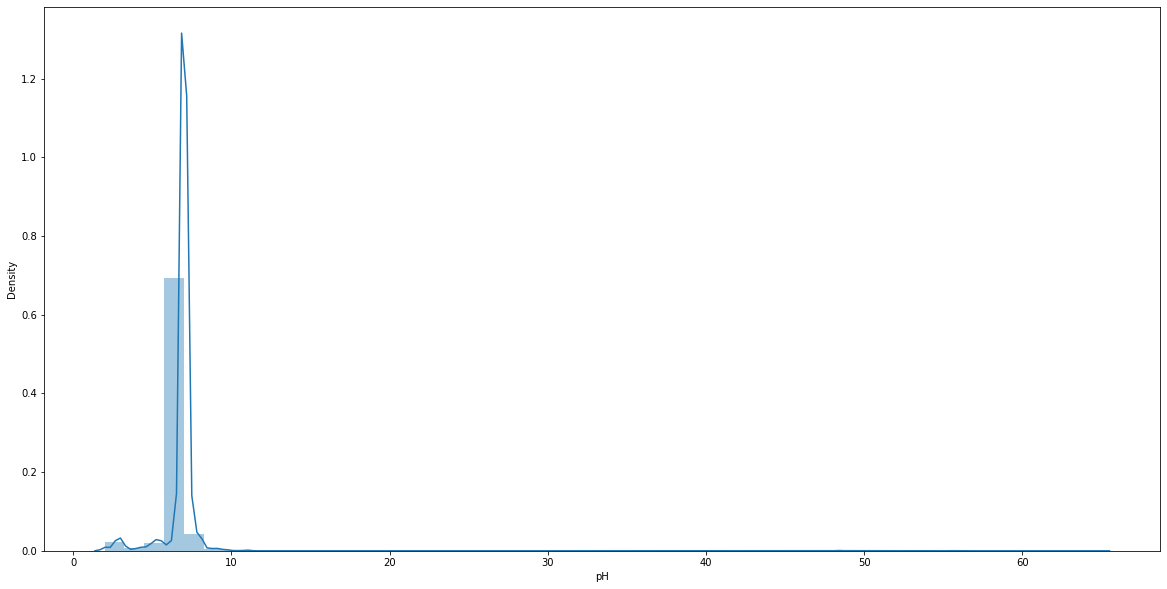

In [91]:
plt.figure(figsize=(20,10))
sns.distplot(df['pH'])

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='pH', ylabel='Density'>

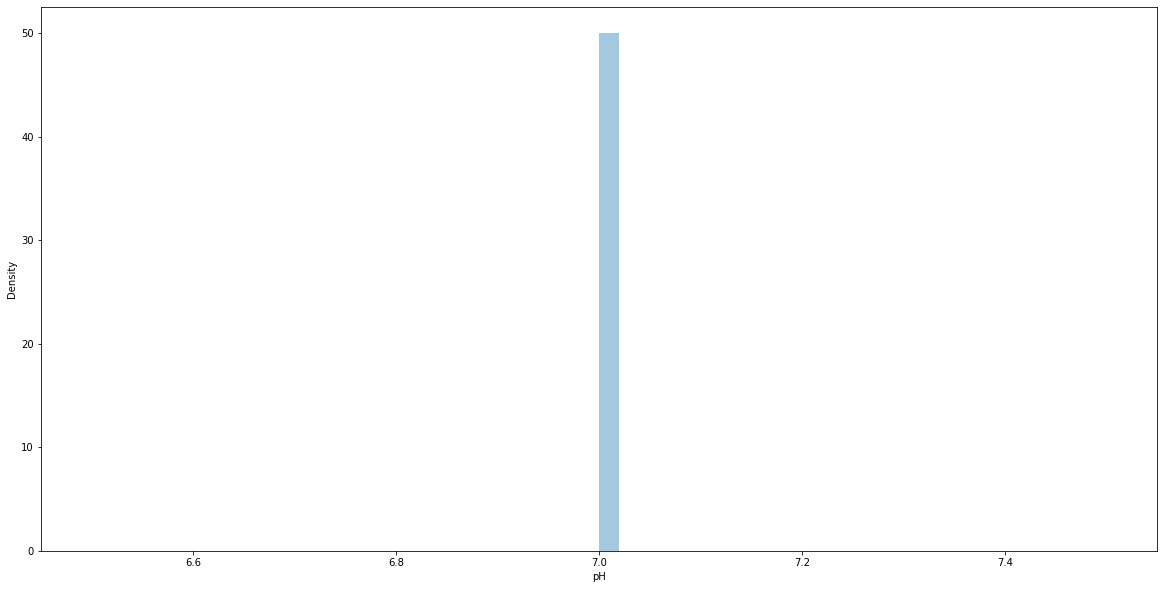

In [92]:
plt.figure(figsize=(20,10))
sns.distplot(df1['pH'])

### Preprocessing

In [171]:
def preprocessing(df):
    #Available Amino acids
    amino_acids= ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    #Converting Respective Protein Sequence into amino acid counts
    for letter in amino_acids:
        df[letter] = df["protein_sequence"].str.count(letter)
      
    df.drop('protein_sequence',axis=1,inplace=True)
    df.drop('seq_id',axis=1,inplace=True)
    df.drop('data_source',axis=1,inplace=True)
    df.dropna(inplace=True)

    


In [94]:
seq_id = df['seq_id']
preprocessing(df)

In [95]:
df.head()

,pH,tm,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,7.0,75.7,45,1,13,30,13,38,3,14,...,8,5,18,6,25,11,14,37,4,3
1,7.0,50.5,28,0,10,52,6,18,4,13,...,2,6,8,22,30,14,12,13,3,3
2,7.0,40.5,50,9,27,32,21,65,11,16,...,6,15,20,25,31,33,30,30,3,16
3,7.0,47.2,20,5,19,29,12,16,7,10,...,2,9,16,9,10,16,19,14,3,4
4,7.0,49.5,86,14,78,78,32,84,40,71,...,31,65,128,54,63,148,120,124,16,47


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31104 entries, 0 to 31389
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pH      31104 non-null  float64
 1   tm      31104 non-null  float64
 2   A       31104 non-null  int64  
 3   C       31104 non-null  int64  
 4   D       31104 non-null  int64  
 5   E       31104 non-null  int64  
 6   F       31104 non-null  int64  
 7   G       31104 non-null  int64  
 8   H       31104 non-null  int64  
 9   I       31104 non-null  int64  
 10  K       31104 non-null  int64  
 11  L       31104 non-null  int64  
 12  M       31104 non-null  int64  
 13  N       31104 non-null  int64  
 14  P       31104 non-null  int64  
 15  Q       31104 non-null  int64  
 16  R       31104 non-null  int64  
 17  S       31104 non-null  int64  
 18  T       31104 non-null  int64  
 19  V       31104 non-null  int64  
 20  W       31104 non-null  int64  
 21  Y       31104 non-null  int64  
dty

### Seperating Dependent and Independent Variables

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [129]:
X = df.drop('tm',axis=1)
# X = scaler.fit_transform(X)
y = df['tm']

### Train Test Split

In [130]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Model Selection

#### SKlearn LinearRegresion Model

In [131]:
from sklearn.linear_model import LinearRegression

In [132]:
lreg = LinearRegression()
lreg.fit(x_train,y_train)

LinearRegression()

In [141]:
pred_lreg = lreg.predict(x_test)

In [142]:
# Evaluation metrics
# Mean Absolute Error (MAE)
# Mean Squared Error (MSE)
# Root Mean Squared Error(RMSE)
from sklearn import metrics

print('MAE :', metrics.mean_absolute_error(y_test, pred_lreg))
print('MSE :', metrics.mean_squared_error(y_test, pred_lreg))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, pred_lreg)))

MAE : 9.575887077755619
MSE : 172.3916215615994
RMSE : 13.129798991667748


#### Stats LinearRegression Model 

In [134]:
import statsmodels.api as sm
x_train = sm.add_constant(x_train)
model = sm.OLS(endog=y_train,exog=x_train)
results = model.fit()

In [135]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     tm   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     132.2
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:47:38   Log-Likelihood:                -87162.
No. Observations:               21772   AIC:                         1.744e+05
Df Residuals:                   21750   BIC:                         1.745e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.7187      0.399    131.996      0.000      51.936      53.502
pH            -0.5314      0.054     -9.777      0.000      -0.638      -0.425
A              0.0167      0.008      2.221      0.026       0.002       0.031
C             -0.1052      0.013     -8.298      0.000      -0.130      -0.080
D             -0.1054      0.012     -9.128      0.000      -0.128      -0.083
E              0.0864      0.009      9.695      0.000       0.069       0.104
F             -0.0967      0.015     -6.382      0.000      -0.126      -0.067
G              0.0813      0.008     10.543      0.000       0.066       0.096
H             -0.0272      0.019     -1.407      0.159      -0.065       0.011
I              0.0603      0.011      5.281      0.000       0.038       0.083
K             -0.1324      0.009    -14.763      0.000      -0.150      -0.115
L              0.1036      0.007     15.181      0.000       0.090       0.117
M             -0.2025      0.019    -10.527      0.000      -0.240      -0.165
N              0.0846      0.013      6.585      0.000       0.059       0.110
P              0.0831      0.008     10.873      0.000       0.068       0.098
Q             -0.1204      0.009    -13.938      0.000      -0.137      -0.103
R              0.1141      0.010     11.007      0.000       0.094       0.134
S             -0.0414      0.007     -5.582      0.000      -0.056      -0.027
T             -0.2167      0.011    -19.021      0.000      -0.239      -0.194
V              0.0629      0.010      6.114      0.000       0.043       0.083
W             -0.0809      0.025     -3.265      0.001      -0.129      -0.032
Y              0.0612      0.016      3.738      0.000       0.029       0.093
==============================================================================
Omnibus:                      778.510   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1378.979
Skew:                           0.298   Prob(JB):                    3.62e-300
Kurtosis:                       4.079   Cond. No.                         870.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [144]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [145]:
rfc = RandomForestClassifier()
rfr = RandomForestRegressor()

In [146]:
rfr.fit(x_train,y_train)

RandomForestRegressor()

In [148]:
pred_rfr = rfr.predict(x_test)

In [149]:
# Evaluation metrics
# Mean Absolute Error (MAE)
# Mean Squared Error (MSE)
# Root Mean Squared Error(RMSE)
from sklearn import metrics

print('MAE :', metrics.mean_absolute_error(y_test, pred_rfr))
print('MSE :', metrics.mean_squared_error(y_test, pred_rfr))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, pred_rfr)))

MAE : 6.334074573406279
MSE : 83.93739484700329
RMSE : 9.161735362200945


## Predictions on Test Data

In [183]:
df_test = pd.read_csv('test.csv')

In [184]:
df_test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [185]:
seq_id = pd.DataFrame(df_test['seq_id'])

In [186]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   seq_id            2413 non-null   int64 
 1   protein_sequence  2413 non-null   object
 2   pH                2413 non-null   int64 
 3   data_source       2413 non-null   object
dtypes: int64(2), object(2)
memory usage: 75.5+ KB


### Calling the preprocessing Function

In [187]:
df_test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [188]:
preprocessing(df_test)

In [189]:
df_test.head()

,pH,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
0,8,22,4,15,8,10,19,0,6,24,...,0,19,17,13,3,18,8,13,6,6
1,8,22,4,15,7,10,19,0,6,25,...,0,19,17,13,3,18,8,13,6,6
2,8,22,4,15,7,10,19,0,6,24,...,0,19,17,13,3,18,8,13,6,6
3,8,22,5,15,7,10,19,0,6,23,...,0,19,17,13,3,18,8,13,6,6
4,8,22,4,15,7,11,19,0,6,23,...,0,19,17,13,3,18,8,13,6,6


### RandomForestRegressor Predictions

In [190]:
predictions = pd.DataFrame(rfr.predict(df_test))
predictions

,0
0,45.365169
1,45.652831
2,45.365169
3,41.890833
4,41.861333
...,...
2408,45.364780
2409,45.111780
2410,45.456780
2411,45.389780


In [191]:
submission = pd.concat([seq_id,predictions],axis=1)

In [195]:
submission.rename(columns={0:'tm'},inplace=True)
submission

,seq_id,tm
0,31390,45.365169
1,31391,45.652831
2,31392,45.365169
3,31393,41.890833
4,31394,41.861333
...,...,...
2408,33798,45.364780
2409,33799,45.111780
2410,33800,45.456780
2411,33801,45.389780


In [198]:
submission.to_csv('submission.csv',index=False)